# Scraped Data
Read in the data written to the `recipes` Postgres table sourced from Epicurious

In [1]:
import matplotlib.pyplot as plt
import psycopg2 as pg
import pandas as pd
import re

In [2]:
def as_url(row):
    """Helper to create a link to check on the Epicurious site
    from a DataFrame row
    """
    print("https://www.epicurious.com/" + row['path'].rstrip('.html'))
    return None

In [3]:
conn = pg.connect('host=localhost dbname=reciplease user=johnny')

In [4]:
df = pd.read_sql_query("""
        SELECT
            path,
            title,
            ingredients,
            instructions,
            misc
        FROM recipes
        WHERE domain = 'www.epicurious.com'
        """,
        conn
)

In [5]:
conn.close()

In [6]:
df.head()

,path,title,ingredients,instructions,misc
0,recipes/food/views/blue-cheese-and-caramelized...,Blue Cheese and Caramelized-Onion Squares,"{'Crust': ['2 cups all purpose flour', '2 teas...",{'For crust:': ['Preheat oven to 425°F. Mix fl...,"{'servings': 'Makes 42 squares', 'description'..."
1,recipes/food/views/cornmeal-and-chile-cumin-co...,Cornmeal-and-Chile-Cumin Coated Pork Loin,"{'part_1': ['1 1/4 lb boneless pork loin, trim...","{'part_1': ['Preheat oven to 350°F.', 'Pat por...","{'servings': 'Makes 4 servings', 'prep_time': ..."
2,recipes/food/views/beet-and-jicama-on-endive-w...,Beet and Jícama on Endive with Garlic Yogurt D...,{'For dressing:': ['32 ounces whole-milk plain...,{'Make dressing:': ['Drain yogurt in a large s...,"{'servings': 'Serves 50', 'prep_time': '1 hour..."
3,recipes/food/views/pate-sucree-51123640.html,Pâte Sucrée,"{'part_1': ['3 large egg yolks', '1/4 cup heav...",{'part_1': ['Whisk egg yolks and cream in a sm...,"{'servings': 'Makes 2 crusts', 'author': 'Suza..."
4,recipes/food/views/candied-spicy-walnuts-23415...,Candied Spicy Walnuts,"{'part_1': ['2 cups water', '2 cups sugar', '1...","{'part_1': ['Combine 2 cups water, sugar, and ...","{'servings': 'Makes 2 cups', 'author': 'Nancy ..."


In [7]:
print(len(df))

36373


## Missing Values
Ideally no titles or ingredient lists are missing

In [8]:
missing_ingredients = df[df.ingredients.isna()]
print(len(missing_ingredients))

97


Not awful out of 36,000 recipes, but still check a few:

In [9]:
missing_ingredients.head()

,path,title,ingredients,instructions,misc
138,recipes/food/views/to-sterilize-jars-and-lids-...,To Sterilize Jars and Lids,None,{'part_1': ['Wash jars thoroughly in hot suds ...,{'description': 'This recipe can be prepared i...
305,recipes/food/views/maple-and-black-pepper-baco...,Maple and Black-Pepper Bacon,None,{'part_1': ['Preheat oven to 375°F with racks ...,"{'servings': 'Makes 8 servings', 'prep_time': ..."
521,recipes/food/views/boiled-carrots-with-prepare...,Boiled Carrots with Prepared Horseradish,None,{'part_1': ['Cut 3 medium carrots into 1/4-inc...,"{'author': 'Todd Gray Ellen Kassoff Gray', 'de..."
761,recipes/food/views/broiled-whole-lobster-10174...,Broiled Whole Lobster,None,{'part_1': ['Lobster is usually split before b...,"{'author': 'James Beard', 'rating': 0.5, 'make..."
1762,recipes/food/views/to-carve-a-rib-roast-15825....,To Carve a Rib Roast,None,"{'part_1': ['For all its grandeur, a standing ...","{'rating': 0.625, 'make_again': 1.0, 'ratings'..."


In [10]:
missing_ingredients.head().apply(as_url, axis=1)

https://www.epicurious.com/recipes/food/views/to-sterilize-jars-and-lids-101506
https://www.epicurious.com/recipes/food/views/maple-and-black-pepper-bacon-350874
https://www.epicurious.com/recipes/food/views/boiled-carrots-with-prepared-horseradish-51154600
https://www.epicurious.com/recipes/food/views/broiled-whole-lobster-101747
https://www.epicurious.com/recipes/food/views/to-carve-a-rib-roast-15825


138     None
305     None
521     None
761     None
1762    None
dtype: object

All 5 examples above had no ingredients on the page, so I am not too worried about the rest of the examples.

In [11]:
missing_titles = df[df.title.isna()]
print(len(missing_titles))

3


In [12]:
missing_titles

,path,title,ingredients,instructions,misc
6455,recipes/seared-scallops-with-tomato-water-lime...,None,None,None,{}
32024,search?page=768.html,None,None,None,{}
35387,search?page=1848.html,None,None,None,{}


Looks like I accidentally had a few search pages in that directory and can ignore. That other links appears to be dead, so I'm not too worried about that one either.

Drop rows with missing `title` and `ingredients` for now.

In [13]:
del missing_titles
del missing_ingredients

In [14]:
df.dropna(axis=0, subset=['title', 'ingredients'], inplace=True)
# Reset the index, dropping the old
df.reset_index(inplace=True, drop=True)

## Redundant Titles
Check a few examples of recipes sharing a title; ideally their ingredients and instructions are still unique

In [15]:
df.title.value_counts()[:10]

Pastry Dough           24
Chicken Stock          20
Simple Syrup           14
Salsa Verde            13
Turkey Stock           12
Turkey Giblet Stock    12
Pizza Dough            11
Caramel Sauce           9
Pickled Red Onions      8
Chocolate Glaze         8
Name: title, dtype: int64

Most seem generic enough; look at a few to ensure they are not duplicates:

In [16]:
df[df.title == 'Pastry Dough'][:10]

,path,title,ingredients,instructions,misc
1722,recipes/food/views/pastry-dough-107043.html,Pastry Dough,"{'part_1': ['2 1/2 cups all-purpose flour', '1...","{'part_1': ['Blend together flour, butter, sho...",{'servings': 'Makes enough for 1 double-crust ...
10391,recipes/food/views/pastry-dough-108789.html,Pastry Dough,"{'part_1': ['1 1/4 cups all-purpose flour', '3...","{'part_1': ['Blend together flour, butter, sho...",{'servings': 'Makes enough dough for 1 (9-inch...
10718,recipes/food/views/pastry-dough-103700.html,Pastry Dough,"{'part_1': ['2 1/2 cups all-purpose flour', '1...","{'part_1': ['Blend together flour, butter, sho...",{'servings': 'Makes enough for a double-crust ...
11748,recipes/food/views/pastry-dough-14445.html,Pastry Dough,{'part_1': ['3/4 stick (6 tablespoons) cold un...,{'part_1': ['Cut butter into 1/2-inch cubes.']...,{'servings': 'Makes enough for a single crust ...
12885,recipes/food/views/pastry-dough-108423.html,Pastry Dough,"{'part_1': ['2 1/2 cups all-purpose flour', '1...","{'part_1': ['Blend together flour, butter, sho...",{'servings': 'Makes enough for 1 double-crust ...
13210,recipes/food/views/pastry-dough-14185.html,Pastry Dough,"{'part_1': ['1 1/4 cups all-purpose flour', '3...",{'part_1': ['In a bowl with a pastry blender o...,{'servings': 'Makes enough dough for a single-...
14388,recipes/food/views/pastry-dough-105948.html,Pastry Dough,"{'part_1': ['1 1/4 cups all-purpose flour', '3...","{'part_1': ['Blend together flour, butter, sho...",{'servings': 'Makes enough dough for a single-...
14852,recipes/food/views/pastry-dough-350598.html,Pastry Dough,"{'part_1': ['2 1/2 cups all-purpose flour', '2...","{'part_1': ['Blend together flour, butter, and...",{'servings': 'Makes enough for 1 (9-inch) doub...
15305,recipes/food/views/pastry-dough-15720.html,Pastry Dough,{'part_1': ['3/4 stick (6 tablespoons) cold un...,{'part_1': ['Cut butter into 1/2-inch cubes.']...,{'servings': 'Makes enough dough for a single-...
16948,recipes/food/views/pastry-dough-101453.html,Pastry Dough,{'part_1': ['3/4 stick (6 tablespoons) cold un...,{'part_1': ['Cut butter into 1/2-inch cubes.']...,{'servings': 'Makes enough dough to decorate 2...


In [17]:
df[df.title == 'French 75'][:10]

,path,title,ingredients,instructions,misc
1307,recipes/food/views/french-75-233902.html,French 75,"{'part_1': ['1 tablespoon fresh lemon juice', ...","{'part_1': ['In cocktail shaker, combine lemon...","{'servings': 'Serves 1', 'description': 'This ..."
12894,recipes/food/views/french-75-200324.html,French 75,"{'part_1': ['Crushed ice', '1 1/2 ounces dry g...",{'part_1': ['Half-fill a 14-ounce collins glas...,{'servings': 'Serves 1. Variations: French 95:...
16694,recipes/food/views/french-75-242668.html,French 75,"{'part_1': ['1 lemon', '3 tablespoons (1 1/2 o...","{'part_1': ['Using zester or paring knife, sli...","{'servings': 'Serves 1', 'author': 'Eben Freem..."
20871,recipes/food/views/french-75-champagne-cocktai...,French 75,"{'part_1': ['2 ounces London dry gin', '3/4 ou...","{'part_1': ['Combine gin, lemon juice, and sim...","{'servings': 'Makes 1', 'author': 'Chris Moroc..."
22701,recipes/food/views/french-75-230612.html,French 75,"{'part_1': ['1 cup water', '1 cup sugar'], 'pa...",{'part_1': ['Stir 1 cup water and 1 cup sugar ...,"{'servings': 'Serves 8', 'rating': 1.0, 'make_..."
24609,recipes/food/views/french-75-104363.html,French 75,"{'part_1': ['Crushed ice', '1 1/2 ounces dry g...",{'part_1': ['Half-fill a 14-ounce collins glas...,"{'servings': 'Makes one drink', 'rating': 0.75..."
31150,recipes/food/views/french-75-367734.html,French 75,"{'part_1': ['1 cup gin', '1/2 cup No-Cook Simp...","{'part_1': ['Stir 1 cup gin, 1/2 cup No-Cook S...","{'servings': 'Makes 8 servings', 'author': 'Bo..."
34624,recipes/food/views/french-75-102791.html,French 75,"{'part_1': ['Crushed ice', '1 1/2 ounces dry g...",{'part_1': ['Half-fill a 14-ounce collins glas...,"{'servings': 'Serves 1', 'rating': 0.875, 'mak..."


Both examples look like they are still separate recipes.

## Recipe Parts
Some recipes come in multiple parts (e.g., a pie recipe might have a section for the filling and a separte for the crust).

I was curious how common this was, so even if a recipe had one section I still included it under a generic `part_1` key

In [18]:
df['ingredient_parts_count'] = df.ingredients.map(lambda x: len(x))

In [19]:
df.ingredient_parts_count.value_counts()

1     20184
2      9297
3      4390
4      1704
5       502
6       134
7        40
8        13
9         8
10        2
12        1
0         1
Name: ingredient_parts_count, dtype: int64

Check that 12 part recipe to see it's not a fluke:

In [20]:
df[df.ingredient_parts_count == 12].apply(as_url, axis=1)

https://www.epicurious.com/recipes/food/views/lemon-berry-wedding-cake-101874


23626    None
dtype: object

Looks like it's just a fancy recipe!

## Ingredient Counts
Ingredient counts could be helpful for searching recipes, such as a checkbox for preferring simpler recipes

In [21]:
def ingredient_count(ingredients):
    """Return a total count of ingredients summed for each part
    """
    return sum(
        [len(ing_list) for ing_list in ingredients.values()]
    )

In [22]:
df['ingredient_count'] = df.ingredients.map(lambda x: ingredient_count(x))

In [23]:
total_counts = df.ingredient_count.value_counts()
total_counts[:10]

9     3621
8     3595
7     3429
10    3147
6     3131
11    2798
5     2556
12    2333
13    1917
4     1789
Name: ingredient_count, dtype: int64

In [24]:
mean_count = df.ingredient_count.mean()

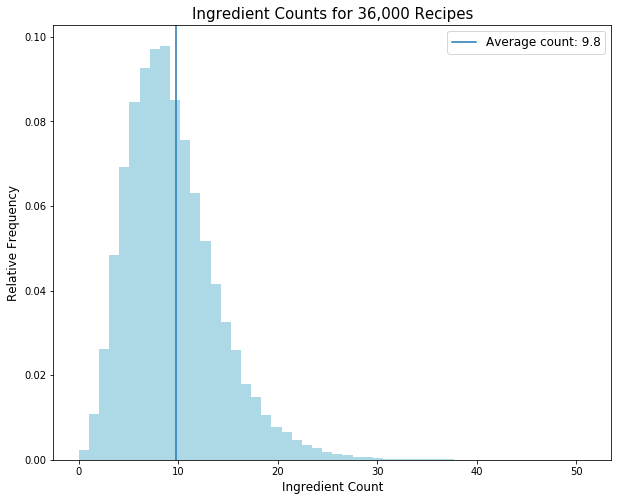

In [25]:
plt.figure(figsize=(10, 8))
plt.hist(df.ingredient_count,
         bins=50,
         density=True,
         facecolor='lightblue')
plt.axvline(mean_count,
            label=f"Average count: {round(mean_count, 1)}")
plt.title('Ingredient Counts for 36,000 Recipes',
          fontsize=15)
plt.xlabel('Ingredient Count',
           fontsize=12)
plt.ylabel('Relative Frequency',
           fontsize=12)
plt.legend(loc='upper right',
           fontsize=12)
plt.show()

Right-skewed with an average of ~9.8 ingredients per recipe.